In [1]:
import os
import json
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F

# Define the dataset

In [2]:
def resize_image_and_target(image, target, size=(128, 128)):
    original_size = image.size
    resize_transform = torchvision.transforms.Resize(size)
    image = resize_transform(image)

    old_width, old_height = original_size
    new_width, new_height = size

    # Пересчитываем bounding boxes для каждого объекта в target
    for obj in target:
        bbox = obj['bbox']

        # bbox обычно содержит формат [x_min, y_min, width, height]
        # Поэтому масштабируем все координаты
        bbox[0] = bbox[0] * (new_width / old_width)  # x_min
        bbox[1] = bbox[1] * (new_height / old_height)  # y_min
        bbox[2] = bbox[2] * (new_width / old_width)  # width
        bbox[3] = bbox[3] * (new_height / old_height)  # height

        # Обновляем bbox в объекте
        obj['bbox'] = bbox

    return image, target


In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
class CocoDeepFashionDataset(CocoDetection):
    def __init__(self, img_dir, ann_file):
        super(CocoDeepFashionDataset, self).__init__(img_dir, ann_file)
        
    def __getitem__(self, idx):
        img, target = super(CocoDeepFashionDataset, self).__getitem__(idx)
        # эта функция делает ресайз изображения и таргета. однако, когда она вызывается не один раз (например, попробуй внизу вызвать её три раза), то она начинает работать некорректно
        img, target = resize_image_and_target(img, target, size=(128, 128))

        img = F.to_tensor(img)
        return img, target

    def __len__(self):
        return super(CocoDeepFashionDataset, self).__len__()
    
    

In [5]:
img_dir = '../deepfashion2/some_train/image'
ann_file = '../deepfashion2/some_train/coco_train.json'

dataset = CocoDeepFashionDataset(img_dir, ann_file)
data_loader = DataLoader(dataset, batch_size=12, num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


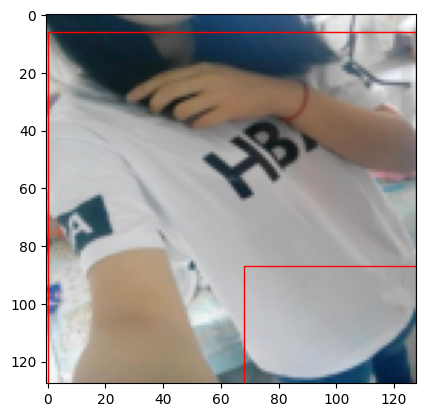

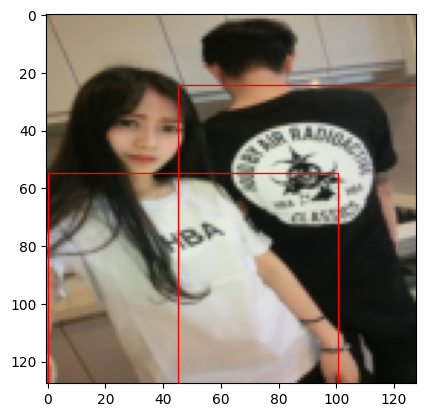

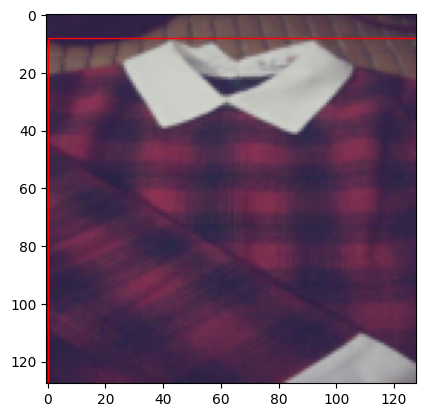

In [6]:
# нарисуем несколько изображений из датасета с боксами и масками    

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(img, target):
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0))

    for obj in target:
        bbox = obj['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

for i in range(3):
    img, target = dataset[i]
    plot_image_with_boxes(img, target)

# Define model training and evaluation functions

In [7]:
# using pre-trained on COCO then finetune it for cloth segmentation data
def get_model_instance_segmentation(num_classes, hidden_layer=256, pretrained_model=True):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained_model)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
model = get_model_instance_segmentation(num_classes=13, hidden_layer=256, pretrained_model=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_model(model, data_loader, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        for imgs, targets in data_loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
        print(f'Epoch {epoch} Loss: {losses}')

In [11]:
train_model(model, data_loader, optimizer, device, num_epochs=5)

AttributeError: 'list' object has no attribute 'items'